In [1]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gs
import glob
from matplotlib.ticker import FormatStrFormatter
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 1.2

In [2]:
def dosplot(directory, subplot, fermi, filelist): 
  #print(filelist)
  keys_up = {}
  keys_down = {}
  for i in filelist: #This loops over all the files in the filelist and generates the dictionary with all the numpy arrays
    l = i.find('_') + 1
    r = i.find('.',l)
    atom = i[l:r] # Simply the atom name
    #print(atom)
    t = np.loadtxt(directory+i) 
    keys_up[atom] = t[:,[0,1]] # We take E (eV) and pdosup(E)
    keys_down[atom] = t[:,[0,2]] # We take E (eV) and pdosdw(E)
  for i in keys_up:
    keys_up[i] = np.fliplr(keys_up[i]) # We flip the array for vertical plotting of the pdos
    keys_down[i] = np.fliplr(keys_down[i])
  #print(keys)
  Compiled = []
  filekey = open(colorkeyfile,'r')
  colorkey = {'null' : 12345}
  for i in filekey:
    colorkey[i.split()[0]] = i.split()[1] #reading in the colorkey
  filekey.close()
  for i in keys_up:
    keys_up[i][:,1] = keys_up[i][:,1] - fermi 
    keys_down[i][:,1] = keys_down[i][:,1] - fermi
  for i in keys_up:
    #print(i.split("_"))
    label_dos = i.split("_")[0] + " $" + i.split("_")[1] + "$"
    subplot.plot(keys_up[i][:,0], keys_up[i][:,1], colorkey[i], label=label_dos) #Plots the curve
    subplot.plot(-keys_down[i][:,0], keys_down[i][:,1], colorkey[i]) #Plots the curve
    subplot.fill_betweenx(keys_up[i][:,1],keys_up[i][:,0], where=keys_up[i][:,1] < 0.0, color=colorkey[i],alpha=0.25) # This fills in the plot
    subplot.fill_betweenx(keys_down[i][:,1],-keys_down[i][:,0], where=keys_down[i][:,1] < 0.0, color=colorkey[i],alpha=0.25)
  subplot.plot([-1000,1000],[0.0,0.0], color='grey',lw=0.45) #Shows the Fermi Level
  subplot.set_xlabel('PDOS (arb. unit)',fontsize=12) #Labels the x-axis

In [3]:
def Symmetries(fstring):
  f = open(fstring,'r')
  x = np.zeros(0)
  for i in f:
    if "high-symmetry" in i:
      x = np.append(x,float(i.split()[-1]))
  f.close()
  return x

    
def bndplot(datafile, fermi, symmetryfile, subplot, upper, lower, labels, color):
  z = np.loadtxt(datafile) #This loads the bandx.dat.gnu file
  z[:,1] = z[:,1] - float(fermi)
  x = np.unique(z[:,0]) #This is all the unique x-points
  bands = []
  bndl = len(z[z[:,0]==x[1]]) #This gives the number of bands in the calculation
  #print(bndl)
  axis = [min(x), max(x), - lower, upper]
  for i in range(0,bndl):
    bands.append(np.zeros([len(x),2])) #This is where we store the bands
  for i in range(0,len(x)):
    sel = z[z[:,0] == x[i]]  #Here is the energies for a given x
    test = []
    for j in range(0,bndl): #This separates it out into a single band
      bands[j][i][0] = x[i]
      bands[j][i][1] = np.multiply(sel[j][1],1.0)
  for i in bands: #Here we plots the bands
    subplot.plot(i[:,0],i[:,1],color=color)
  temp = Symmetries(symmetryfile)
  for j in temp: #This is the high symmetry lines
    x1 = [j,j]
    x2 = [axis[2],axis[3]]
    subplot.plot(x1, x2, '--', lw=0.55, color='black', alpha=0.75)
  subplot.plot([min(x),max(x)], [0, 0], color='grey',lw=0.45)
  subplot.set_xticks(ticks=temp, labels=labels)
  subplot.set_ylim([axis[2],axis[3]])
  subplot.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  subplot.set_xlim([axis[0],axis[1]])
  subplot.set_xlabel('K-vector',fontsize=12)
  subplot.set_ylabel('$E-E_\mathrm{F}$ (eV)',fontsize=12)
  subplot.tick_params(axis='both',which='major',labelsize=8)
 

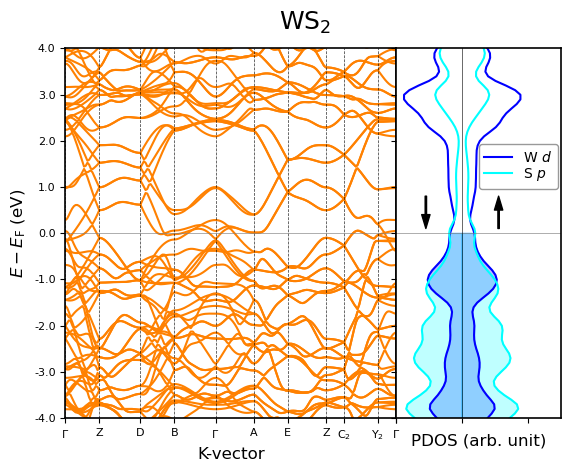

In [14]:
colorkeyfile = "color.key" #To add color to your lines
fontsize = 16 
xlim = [-10,15] #This is the y limits of your subplots
ylim = [-20,30] #The x limits of your subplots    
upper = 4 #upper limit of y axis
lower =4 #lower limit of y axis
Efermi = 10.6336 #Fermi energy 
band_data = '../bands/bands.dat.gnu' # *.gnu file coming from the output of bands.x
bands_pp_out = '../bands/ws2.bands-pp.out'  # *.out file is the symmetries file
title = 'WS$_2$'
color="#FF8101" #color for plotting the bands 

filelist = ['WS2_W_d.dat', 'WS2_S_p.dat'] #list of files containg the pDOS data
dos_loc = "../dos/" # location of the above files
labels=(['$\Gamma$', 'Z', 'D', 'B', '$\Gamma$', 'A', 'E', 'Z', 'C$_2$', 'Y$_2$', '$\Gamma$']) #name of the high symmetric K-points
legend_loc=(0.5,0.62) #location of the legend in DOS plot

#################################################################################

gs1 = gs.GridSpec(1,2,width_ratios=[6,3]) # Creating the subplots
gs1.update(wspace=0,hspace=0.0) # I want them right next to eachother
BND = plt.subplot(gs1[0,0]) #My band diagram
DOS = plt.subplot(gs1[0,1]) #My DOS plot

#This is my bndplot with 'band_data' coming from the output of bands.x, Efermi is the fermi level, 'bands_pp_out' is the symmetries file
bndplot(band_data, Efermi, bands_pp_out, BND, upper, lower, labels, color)
ylim = BND.get_ylim()

dosplot(dos_loc, DOS, Efermi, filelist) #This is my DOS plot with Efermi being the fermi level
DOS.set_ylim(BND.get_ylim()) #Placing the same y-limits
DOS.set_xlim(xlim) #This was defined above
DOS.axes.get_yaxis().set_ticklabels([]) #No Tick Labels
DOS.axes.get_xaxis().set_ticklabels([]) #No Tick Lavels
DOS.plot([0.0,0.0], ylim,lw=0.55,color='black',alpha=0.75)
DOS.legend(fontsize=10,edgecolor="grey",loc=legend_loc, labelspacing = 0.1) #upper center center right
plt.suptitle(title, y=0.96, fontsize=18) #A Title for the Plot
#plt.show()

#adding the up and down arrows to show up and down spin
DOS.annotate('', xy=(5.5,0.8), xytext=(5.5,0.10), arrowprops={ 'width': 1, 'headwidth': 6,'headlength': 10,  'color': 'black'})
DOS.annotate('', xy=(-5.5,0.10), xytext=(-5.5,0.8), arrowprops={ 'width': 1, 'headwidth': 6,'headlength': 10,  'color': 'black'})

plt.savefig('bands_pdos.png', dpi = 300, bbox_inches='tight')

#################################################################################

In [ ]:
# https://blog.levilentz.com/combined-band-diagram-and-pdos/

In [ ]:
# https://pranabdas.github.io/espresso/resources